In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from datetime import date, timedelta
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import spotpy
from scipy import stats

import cartopy.feature as cfeature
import cartopy.crs as ccrs
import cartopy
import colorcet as cc
from cmcrameri import cm
import matplotlib as mpl
import proplot as pplt
import xarray
#warning
import warnings
warnings.filterwarnings('ignore')

dir_in = 'D:/Xanthos-Repo/Data for Figures-Xanthos WM'

d:\Miniconda3\envs\guteEnv\lib\site-packages\geopandas\_compat.py:106: UserWarning: The Shapely GEOS version (3.9.1dev-CAPI-1.14.1) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
#############################################################
basinName = pd.read_csv(dir_in + '/BasinNames235.txt')
basin_id = pd.read_csv(dir_in + '/basin.csv')
GRDC_xanthosCoordIndx = pd.read_csv(dir_in + '/GRDC_stations_list.csv')
Xanthos_grid_areas = np.array(pd.read_csv(dir_in + '/Grid_Areas_ID.csv'))*1e-2 #Km2
grdc_basin_m3persec  =  pd.read_csv(dir_in + '/grdc_91basin_m3persec_1971_1990_monthly.csv')

n_basin = GRDC_xanthosCoordIndx.shape[0]
basins94 = np.array(GRDC_xanthosCoordIndx['basins']).astype(np.int64)
xanthosid = np.array(GRDC_xanthosCoordIndx['xanthosID_new_adj']).astype(np.int64)
basinName_94 = [basinName['Basin_Name'][basins94[ii] - 1] for ii in range(n_basin)]
reservoirs_halfDegree = xarray.open_dataset(dir_in + '/Xanthos_reservoirs_halfDegree_global.nc')

In [3]:
#GRDC
dir_usgrid = dir_in + '/UScells/contributing_grids_all'
grdc_mmmPermonth = np.zeros([91, 240])
grdc_m3persec = np.zeros([91, 240])
SI_grdc = np.zeros([91,])
for ii in range(91):
    
    basin_num = basins94[ii]
    datad = (np.array(pd.read_csv(dir_usgrid + str(basin_num) + '.csv',header=None)) - 1).astype(np.int64)
    basin_idx = np.squeeze(datad)
    
    aa = (grdc_basin_m3persec['basin'] == basin_num)
    us_area = np.max([GRDC_xanthosCoordIndx['area'][ii], GRDC_xanthosCoordIndx['US_Area_SKM'][ii]])   

    ####
    #us_area = GRDC_xanthosCoordIndx['US_Area_SKM'][ii]
    grdc_mmmPermonth[ii,:] = np.array(grdc_basin_m3persec[aa]['q'])*(30.4*24*3600)/us_area/1e3 
    grdc_m3persec[ii,:] = np.array(grdc_basin_m3persec[aa]['q'])

In [4]:
def data_seasonality(data_ts):
    mean_monthly = data_ts.groupby(data_ts.index.month).mean()
    mean_annual  = mean_monthly.sum()
    SI = np.sum(np.abs(mean_monthly - (mean_annual/12))) / mean_annual
    return np.array(SI)[0]

In [5]:
def timeseries_coverter(data_array, start_yr, ending_yr):
    sdate = date(start_yr,1,1)
    edate = date(ending_yr, 12, 31)  
    data_ts = pd.DataFrame(data_array)
    data_ts.index = pd.date_range(start=sdate, end=edate, freq='MS')

    return data_ts

In [6]:
def data_CV(data_ts):
    _annual = data_ts.resample('A').mean()
    mean_annual = _annual.mean()
    std_annual  = _annual.std()
    cv_ = std_annual / mean_annual 

    return np.array(cv_)[0]

In [7]:
ppose = reservoirs_halfDegree.Main_Use.values
Capacity = reservoirs_halfDegree.Capacity.values
Basin = reservoirs_halfDegree.Basin.values
Lon = reservoirs_halfDegree.Lon.values
Lat = reservoirs_halfDegree.Lat.values
Xanthos_Catch_SKM = reservoirs_halfDegree.Xanthos_Catch_SKM.values

# directory for reservoir release data
file_dir_hp_RR = dir_in + '/Simulated/SimulatedFinal-HP/reservoirRelease/'
file_dir_fc_RR = dir_in + '/Simulated/SimulatedFinal-FC/reservoirRelease/'

file_dir_hp_SS = dir_in + '/Simulated/SimulatedFinal-HP/reservoir/'
file_dir_fc_SS = dir_in + '/Simulated/SimulatedFinal-FC/reservoir/'

dir_usgrid = dir_in + '/UScells/contributing_grids_all'

## Release and Storage

In [8]:
nrmse_hpfc_all_release = None
Nhp = 296
rsim_hp_rr=np.zeros([Nhp, 240])
rsim_fc_rr=np.zeros([Nhp, 240])
rsim_hp_ss=np.zeros([Nhp, 240])
rsim_fc_ss=np.zeros([Nhp, 240])
xx = 0
for jj in range(len(basins94)):
    # get grids u/s of GRDC site
    basin_num = basins94[jj]
    basin_namex = basinName_94[jj]
    #annual_mean_flowGRDC = GRDC_xanthosCoordIndx['r_volume_yr'][jj] #KM3
    annual_mean_flowGRDC = np.mean(grdc_m3persec[jj,:])*365*24*3600*1e-9#KM3

    datad = (np.array(pd.read_csv(dir_usgrid + str(basin_num) + '.csv',header=None)) - 1).astype(np.int64)
    basin_idx = np.squeeze(datad) 
    basin_idx = basin_idx[basin_idx>0]
    # reservoirs properties for grids u/s of GRDC sites
    ppose_allgrid = ppose[basin_idx]
    capac_allgrid = Capacity[basin_idx]
    Lon_allgrids = Lon[basin_idx]
    Lat_allgrdis = Lat[basin_idx]
    da_allgrids = Xanthos_Catch_SKM[basin_idx]
    # reservoir grids
    ppose_basin = ppose_allgrid[(ppose_allgrid>0)]
    capac_basin = capac_allgrid[(ppose_allgrid>0)]
    Lon_basin = Lon_allgrids[(ppose_allgrid>0)]
    Lat_basin = Lat_allgrdis[(ppose_allgrid>0)]

    # get HP reservoirs grid us/s for GRDC
    ppose_HP = ppose_basin[ppose_basin==1]
    capac_HP = capac_basin[ppose_basin==1]
    Lon_HP = Lon_basin[ppose_basin==1]
    Lat_HP = Lat_basin[ppose_basin==1]
    indx_basin = np.where((ppose_basin==1))[0]

    ## simulated release
    data_basin_hp_rr = np.load(file_dir_hp_RR + 'ReservoirsRelease_' + str(basin_num) + '.npy') 
    data_basin_fc_rr = np.load(file_dir_fc_RR + 'ReservoirsRelease_' + str(basin_num) + '.npy')   
    ## simulated storage
    data_basin_hp_ss = np.load(file_dir_hp_SS + 'SimReservoirs_' + str(basin_num) + '.npy') 
    data_basin_fc_ss = np.load(file_dir_fc_SS + 'SimReservoirs_' + str(basin_num) + '.npy')   
    
    if indx_basin.shape[0] > 0:
        z = np.zeros([indx_basin.shape[0],])
        for ii in range(indx_basin.shape[0]):
            mm = indx_basin[ii]
            ## release
            # with hydropower
            rsim_hp_rr[xx,:]= data_basin_hp_rr[mm,:]
            # with flood control
            rsim_fc_rr[xx,:]= data_basin_fc_rr[mm,:]

            ## storage
            # with hydropower
            rsim_hp_ss[xx,:]= data_basin_hp_ss[mm,:]
            # with flood control
            rsim_fc_ss[xx,:]= data_basin_fc_ss[mm,:]

            xx+=1

        nrmse_hpfc_df_release = pd.DataFrame()
        nrmse_hpfc_df_release['Lon'] = Lon_HP
        nrmse_hpfc_df_release['Lat'] = Lat_HP
        nrmse_hpfc_df_release['basin'] = basin_num
        nrmse_hpfc_df_release['basinName'] = basin_namex
        # capacity
        nrmse_hpfc_df_release['CAP'] = capac_HP
        nrmse_hpfc_df_release['RII'] = capac_HP*1e-3 / annual_mean_flowGRDC

        if nrmse_hpfc_all_release is None:
            nrmse_hpfc_all_release = nrmse_hpfc_df_release
        else:
            nrmse_hpfc_all_release = pd.concat([nrmse_hpfc_all_release, nrmse_hpfc_df_release],0).reset_index(drop=True)


In [176]:
rsim_hp_ss_df = pd.DataFrame(rsim_hp_ss *1e-6)
rsim_fc_ss_df = pd.DataFrame(rsim_fc_ss *1e-6)
#rsim_hp_ss_df = pd.DataFrame(rsim_hp_rr)
#rsim_fc_ss_df = pd.DataFrame(rsim_fc_rr)
df_diffx = np.divide(rsim_hp_ss_df - rsim_fc_ss_df  , 0.5*(rsim_hp_ss_df + rsim_fc_ss_df))
df_diff = df_diffx.copy()
df_diff[(df_diffx <= 0)] = np.nan
df_diff[(df_diffx > 0)] = 1
x =df_diff.sum(axis=1) / df_diff.shape[1]
len(x[x>=0.5]) #/ 296

150

In [167]:
x1 = np.divide(rsim_hp_ss_df.std(axis=1) * 100, rsim_hp_ss_df.mean(axis=1))
x2 = np.divide(rsim_fc_ss_df.std(axis=1)*100 , rsim_fc_ss_df.mean(axis=1))

In [169]:
len(np.where(x1>x2)[0])

145

In [53]:
# selecting reservoirs to plot
one_reservoir_per_basin = nrmse_hpfc_all_release.groupby('basinName').max('RII')
sorted_based_on_RII = one_reservoir_per_basin.sort_values(by = 'RII',ascending=False)
sorted_based_on_RII['BasinName'] = sorted_based_on_RII.index
sorted_based_on_RII['GRIDCODE'] = sorted_based_on_RII['basin']
sorted_based_on_RII = sorted_based_on_RII.reset_index(drop=True)
#sorted_based_on_RII

## RII + Basin Polygons

In [54]:
#basin_235_xanthos = gpd.read_file('D:\\GCAM-Manuscript\\Figurers\\Data Spatial Map\\basin_235_xanthos\\basin_harmed.shp')
basin_235_xanthos = gpd.read_file('D:\\Xanthos-Repo\\basin_harmed\\basin_harmed.shp')
for ii in range(sorted_based_on_RII.shape[0]):
    basin_num = sorted_based_on_RII['basin'][ii]
    #################
    indx_poly = np.where(basin_235_xanthos['GRIDCODE']==basin_num)[0]
    basin_235_xanthos.loc[indx_poly,'RII'] = sorted_based_on_RII['RII'][ii]
    basin_235_xanthos.loc[indx_poly,'BasinName'] = sorted_based_on_RII['BasinName'][ii]    

In [55]:
##basin_235_xanthos = gpd.read_file('D:\\GCAM-Manuscript\\Figurers\\Data Spatial Map\\basin_235_xanthos\\basin_harmed.shp')
#basin_235_xanthos = gpd.read_file('D:\\Xanthos-Repo\\basin_harmed\\basin_harmed.shp')
#basin_235_xanthos_RII = basin_235_xanthos.merge(sorted_based_on_RII, on='GRIDCODE')


#os.chdir('C:\\Users\\gwabeshu.COUGARNET\\OneDrive - University Of Houston\Desktop\\Xanthos-Manuscript\\Manuscript\\Revision-06\\Figures-List-08-22-2022\\RII')
#basin_235_xanthos_RII.to_file('basin_selected_xanthos_RII.shp')


#### Categorize the classes

In [56]:
basin_235_xanthos_RII = basin_235_xanthos
p1 = np.where(basin_235_xanthos_RII['RII']<=0.25)[0]                                                                              
p2 = np.where((basin_235_xanthos_RII['RII'] > 0.25) & (basin_235_xanthos_RII['RII']<=0.5))[0]    
p3 = np.where((basin_235_xanthos_RII['RII'] > 0.5) & (basin_235_xanthos_RII['RII']<=0.75))[0]    
p4 = np.where((basin_235_xanthos_RII['RII'] > 0.75) & (basin_235_xanthos_RII['RII']<=1.5))[0]    
p5 = np.where(basin_235_xanthos_RII['RII'] > 1.5)[0]     

#############
basin_235_xanthos_RII['RIIGroup'] = np.nan
basin_235_xanthos_RII.loc[p1, 'RIIGroup'] = r'$0 - 0.25$'
basin_235_xanthos_RII.loc[p2, 'RIIGroup'] = r'$0.25 - 0.5$'
basin_235_xanthos_RII.loc[p3, 'RIIGroup'] = r'$0.5 - 0.75$'
basin_235_xanthos_RII.loc[p4, 'RIIGroup'] = r'$0.75 - 1.5$'
basin_235_xanthos_RII.loc[p5, 'RIIGroup'] = r'$1.5 - 5.3$'

In [57]:
from matplotlib.ticker import MaxNLocator
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10
plt.rcParams['figure.autolayout'] = True 
plt.rcParams.update({'font.size': 10, 'font.weight':'bold'}) 
plt.rcParams["axes.labelweight"] = 'bold'
plt.rcParams["axes.titleweight"] = 'bold'


def plot_basin_data(basins_selected):
    plt.style.use('science')
    with plt.style.context(['science', 'high-contrast']):
        ii = 0##
        for basin_idx in basins_selected:
            #fig, axs =  pplt.subplots(ncols=1, nrows=1,refheight=1.10, refwidth=1.30, share=0, journal='nat1')
            if ii==0:#a
                axs = plt.axes([0, 0.9, .25, .25], facecolor='none')
            if ii==1:#b
                axs = plt.axes([0.375, 0.9, .25, .25], facecolor='none')
            if ii==2:#c
                axs = plt.axes([0.75, 0.9, .25, .25], facecolor='none')
            if ii==3:#d
                axs = plt.axes([-0.125, 0.55, .25, .25], facecolor='none')         
            if ii==4:#e
                axs = plt.axes([-0.125, 0.2, .25, .25], facecolor='none')
            if ii==5:#f
                 axs = plt.axes([0, -0.15, .25, .25], facecolor='none')
            if ii==6:#g
                axs = plt.axes([0.375, -0.15, .25, .25], facecolor='none')
            if ii==7:#h
                 axs = plt.axes([0.75, -0.15, .25, .25], facecolor='none')
            if ii==8:#i
                 axs = plt.axes([0.875, 0.55, .25, .25], facecolor='none') 
            if ii==9:#j
                 axs = plt.axes([0.875, 0.2, .25, .25], facecolor='none')   

            # get grids u/s of GRDC site
            basins_property = sorted_based_on_RII[sorted_based_on_RII['GRIDCODE']==basin_idx]
            basin_numx = basins_property['basin'].values[0] 
            capac_HPx = basins_property['CAP'].values[0] 
            RIIx = basins_property['RII'].values[0] 
            name_basinx = basins_property['BasinName'].values[0]  
            indx_ = np.where((nrmse_hpfc_all_release['basin']==basin_numx) & 
                            (nrmse_hpfc_all_release['CAP']==capac_HPx) &
                            (nrmse_hpfc_all_release['basinName']==name_basinx))[0][0]
            #####---###
            ## simulated hp
            data_basin_hp = rsim_hp_ss[indx_,180:240] *1e-9
            Ssim_tshp = timeseries_coverter(data_basin_hp, start_yr=1986, ending_yr=1990)

            ## simulated fc
            data_basin_fc = rsim_fc_ss[indx_,180:240]  *1e-9
            Ssim_tsfc = timeseries_coverter(data_basin_fc, start_yr=1986, ending_yr=1990)
            # plot
            ax=axs  
            hs = ax.plot(np.divide((Ssim_tshp - Ssim_tsfc), 0.5*(Ssim_tshp + Ssim_tsfc))*100,'red', linewidth=1.0, linestyle='-', label='Storage: Xanthos-enhanced-sim')       
            ax.format(abc=False, title = name_basinx  + '[RII=' + str(round(RIIx,3)) +']', grid=False,  titleloc='c', xrotation=0)    
            ax.set_ylabel(ylabel = 'S-RD (\%)',color='r') 
            ax.spines['left'].set_color('red')
            ax.tick_params(axis='y', which='both', colors='red')
            ax.yaxis.set_major_locator(MaxNLocator(5)) 


            #ax.set_ylim([0, np.round(capac_HPx*1e-3,2)])


            ##########################################
            # with hydropower
            rsim_hp= rsim_hp_rr[indx_,:]
            rsim_HPts = timeseries_coverter(rsim_hp[180:240], start_yr=1986, ending_yr=1990)
            # with flood control
            rsim_fc= rsim_fc_rr[indx_,:]
            rsim_FCts = timeseries_coverter(rsim_fc[180:240], start_yr=1986, ending_yr=1990)
            # plot
            ax2=ax.twinx()
            hs2 = ax2.plot(np.divide((rsim_HPts - rsim_FCts), 0.5*(rsim_HPts + rsim_FCts))*100, 'b',linewidth=1.0, linestyle='-', label='Release: Xanthos-enhanced-sim')  
            ax2.format(abc=False, ylabel = 'R-RD (\%)',color='b',grid=False , xrotation=0)     
            ax2.yaxis.set_major_locator(MaxNLocator(5))  

            if ii==9:
                axleg = plt.axes([.45, .1, .2, .3], facecolor='none')
                axleg.legend([hs, hs2], title=False, ncol=1, frame=False, loc='center left', labelspacing=0.2, fontsize=14)#, bbox_to_anchor=(1.5, -1.0))
                axleg.axis(False)
                axleg.xaxis.label.set_visible(False)
                axleg.yaxis.label.set_visible(False)



            ii += 1##


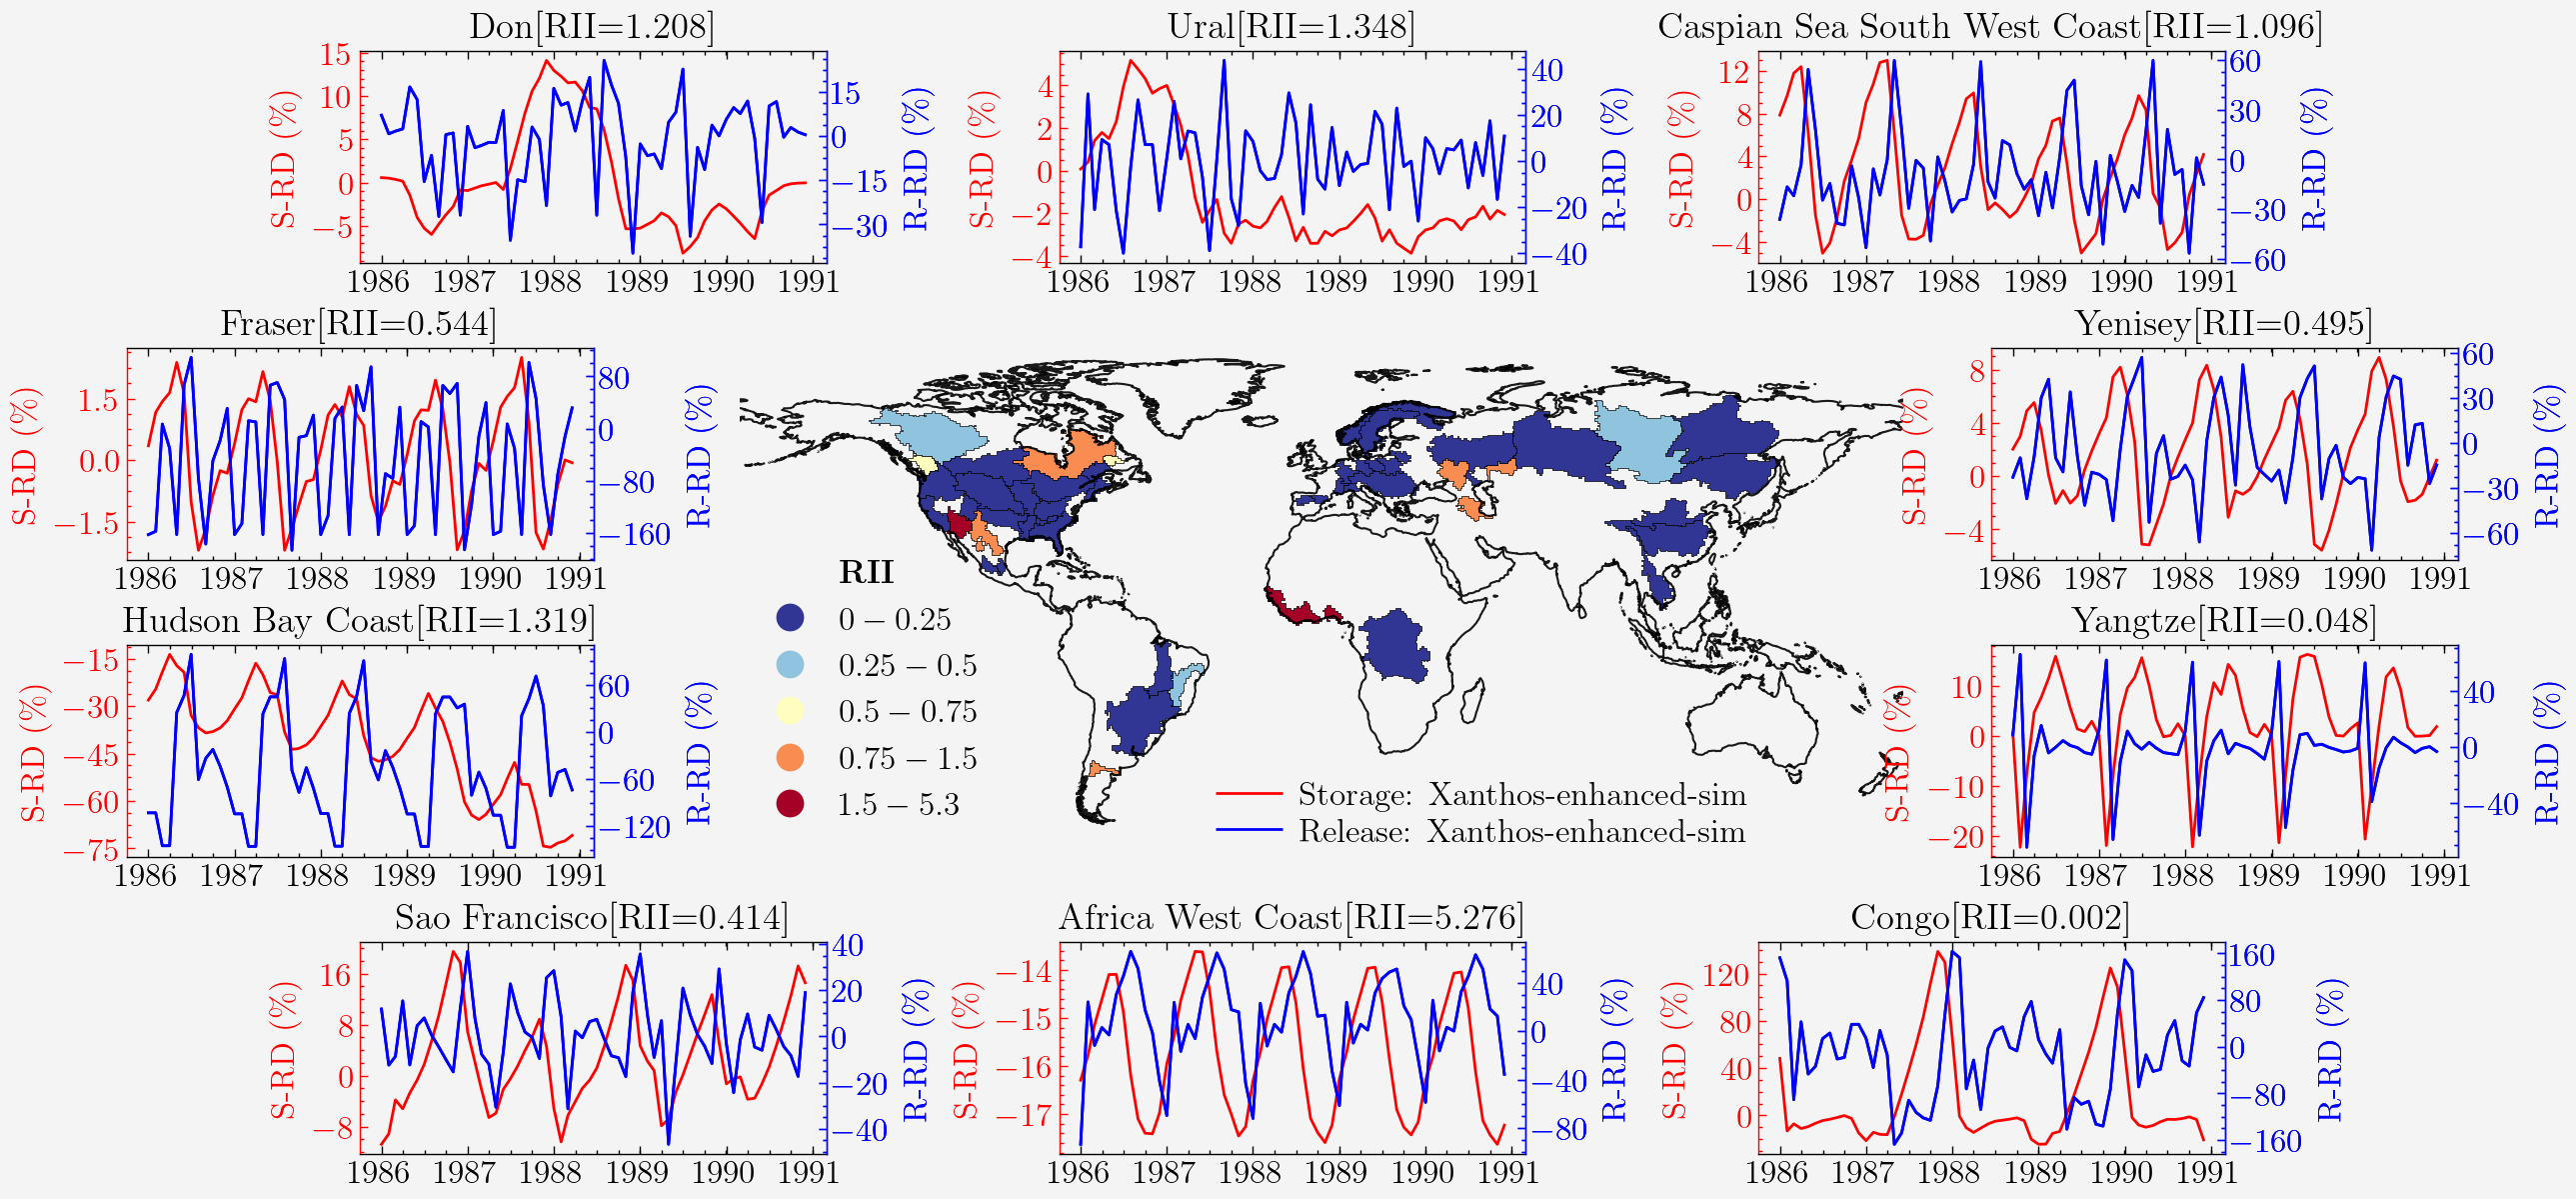

In [58]:
import xarray 
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import proplot as pplt

mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.autolayout'] = True 
plt.rcParams.update({'font.size': 12, 'font.weight':'bold'}) 



plt.rcParams["axes.labelweight"] = 'bold'
plt.rcParams["axes.titleweight"] = 'bold'

CRS = "EPSG:4326"
## Ploting
SAVE_KWDS = {"bbox_inches": "tight", "dpi": 450, "facecolor": "w"}
BASE_PLOT = {"facecolor": 'none', "edgecolor": 'k', "alpha": 0.9,"linewidth":0.75}

world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
global_shape = gpd.GeoDataFrame(geometry=world.geometry, crs=world.crs)
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

#coastlines
#coastlines
coastlines_path = 'D:\\Xanthos-Repo\\ne_50m_coastline\\ne_50m_coastline.shp'
coastlines = gpd.read_file(coastlines_path)
# rivers
rivers = gpd.read_file('D:\\Xanthos-Repo\\Xanthos-Manuscript\\figures\\codes\\Figure-3\\world_rivers_dSe\\world_rivers_dSe.shp')

N=10
c = np.linspace(-N / 2, N / 2, N + 1)
fig, axes = pplt.subplots(nrows=1, ncols=1, share=0, space = 2, refheight='2.5')
plt.style.use('science')
with plt.style.context(['science', 'high-contrast']):
        # GranD
        ax = axes
        coastlines.to_crs(CRS).plot(ax=ax,**BASE_PLOT)  
        basin_235_xanthos_RII.to_crs(CRS).plot(ax=ax, column='RIIGroup', cmap='RdYlBu_r', 
                                         categorical=True,  edgecolor='k',linewidth=0.25,
                                         legend=True,
                                         legend_kwds={'loc': 'lower left',
                                                       'ncols':1,
                                                       'label' : r'$\bf{{{RII}}}$',
                                                       'edgecolor':'black',
                                                       'facecolor':'white'
                                                       }
                                                       )                                                                                  
        ax.axis(False)
        ax.xaxis.label.set_visible(False)
        ax.yaxis.label.set_visible(False)
        ax.autoscale(tight=True)  
        ax.set_ylim([-60,90])   
        #ax.format(abc=False,  titleweight = 'bold', titleloc='l',abcstyle=False, fontsize=12)
        #ax.legend(bbox_to_anchor=(1.0, .5), prop={'size': 12})
        basins_selected_all = [53, 38, 72, 27,15,192,142,183,48, 106]
        plot_basin_data(basins_selected_all)



#dir_out = 'C:\\Users\\gwabeshu.COUGARNET\\OneDrive - University Of Houston\\Desktop\Xanthos-Manuscript\\Manuscript-09072022\\Figures-Updated\\'
#plt.savefig(dir_out  + "Figure-9-Map+Time-Series-HPFC.png", **SAVE_KWDS)    